In [1]:
import pandas as pd
from utils import preprocess, plot_average_costs, costs_to_moving_avg, print_stats, plot_categorical_distr, plot_numerical_distr, plot_correlation, get_top_correlations
from cb import simulate, evaluate
from vowpalwabbit import Workspace
import numpy as np
import matplotlib.pyplot as plt
from pandas.api.types import is_object_dtype
import os

In [2]:
test_path = os.path.join("data", "test.csv")
train_path = os.path.join("data", "train.csv")
submission_path = os.path.join("data", "submission.csv")

In [3]:
df = pd.read_csv(train_path)

## EDA ##

In [4]:
print_stats(df)

head


,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


description


,id,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE
count,20758.00000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,10378.50000,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756
std,5992.46278,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113
min,0.00000,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,5189.25000,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000
50%,10378.50000,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887
75%,15567.75000,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000
max,20757.00000,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000


info
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   id                              20758 non-null  int64  
 1   Gender                          20758 non-null  object 
 2   Age                             20758 non-null  float64
 3   Height                          20758 non-null  float64
 4   Weight                          20758 non-null  float64
 5   family_history_with_overweight  20758 non-null  object 
 6   FAVC                            20758 non-null  object 
 7   FCVC                            20758 non-null  float64
 8   NCP                             20758 non-null  float64
 9   CAEC                            20758 non-null  object 
 10  SMOKE                           20758 non-null  object 
 11  CH2O                            20758 non-null  float64
 12  SCC                        

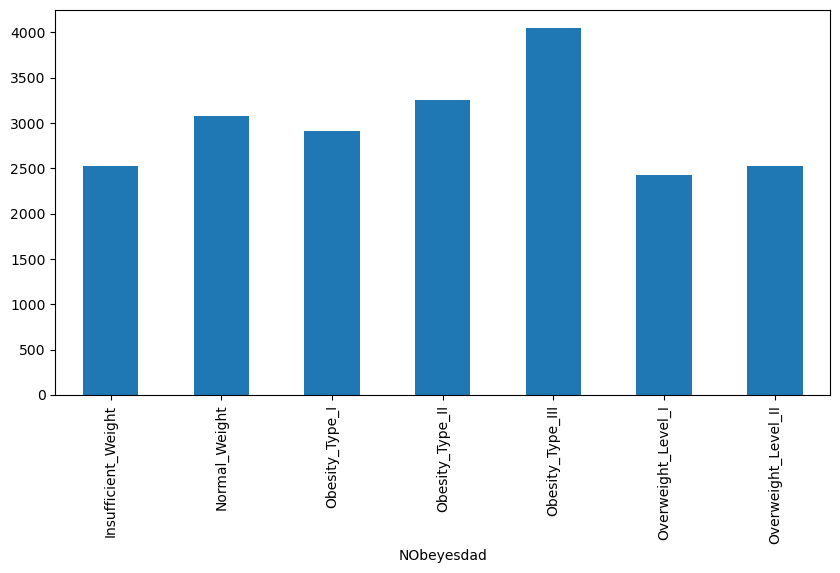

In [5]:
y_col = "NObeyesdad"
plot_categorical_distr(df, [y_col], (10, 5))

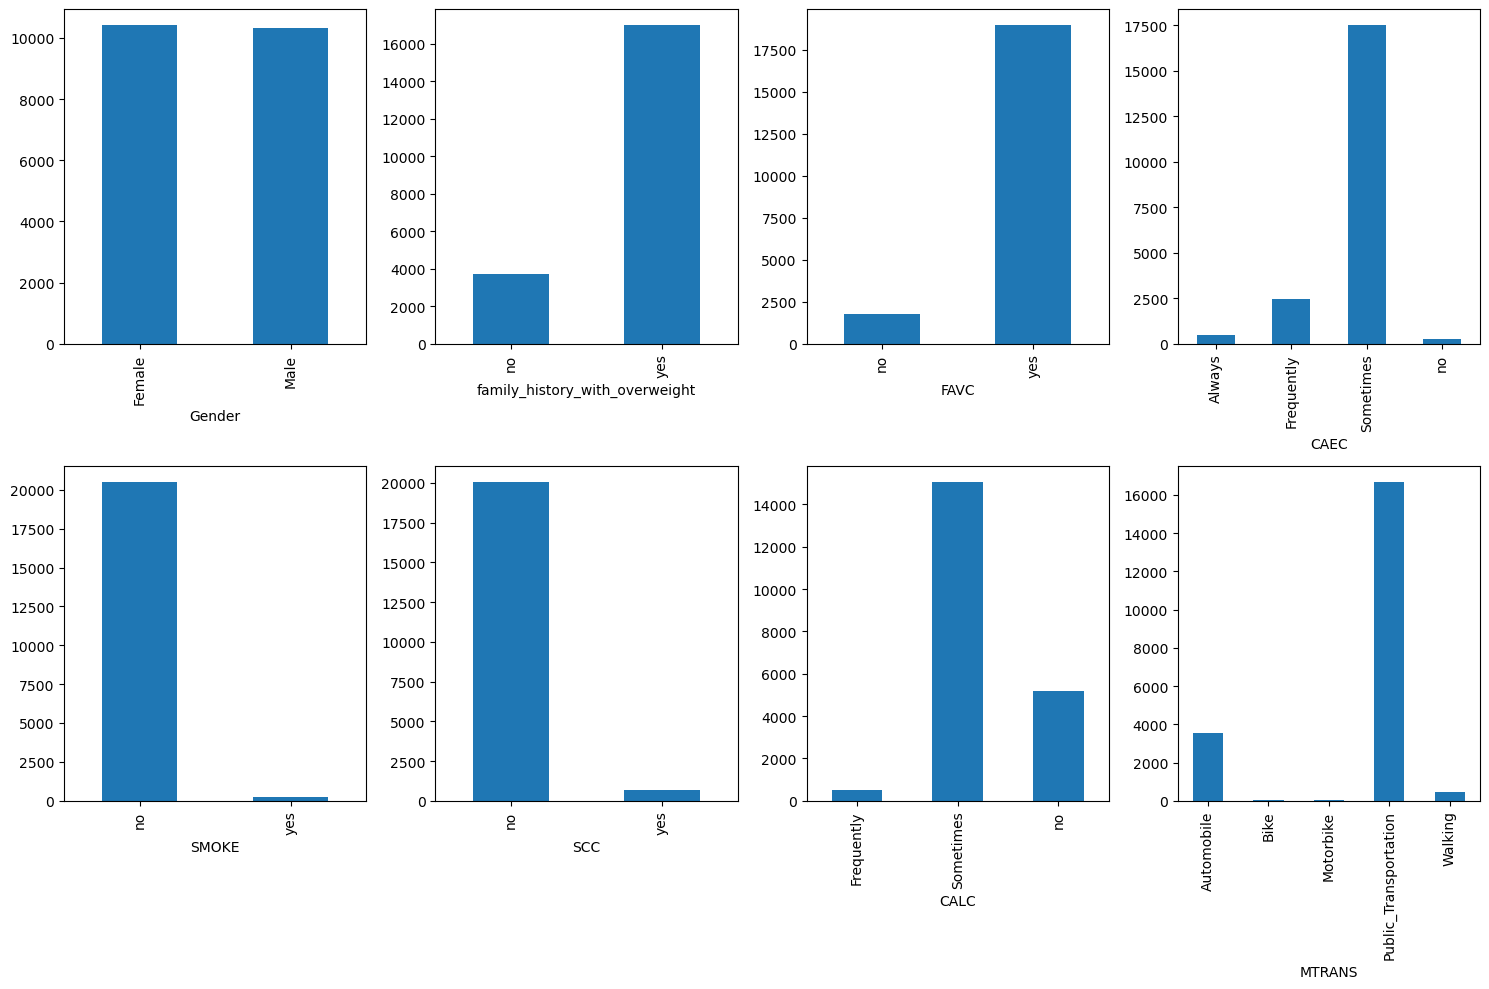

In [6]:
categorical_cols  = [name for name, col in df.items() if is_object_dtype(col) and name != y_col]
plot_categorical_distr(df, categorical_cols, (15, 10))
plt.tight_layout()

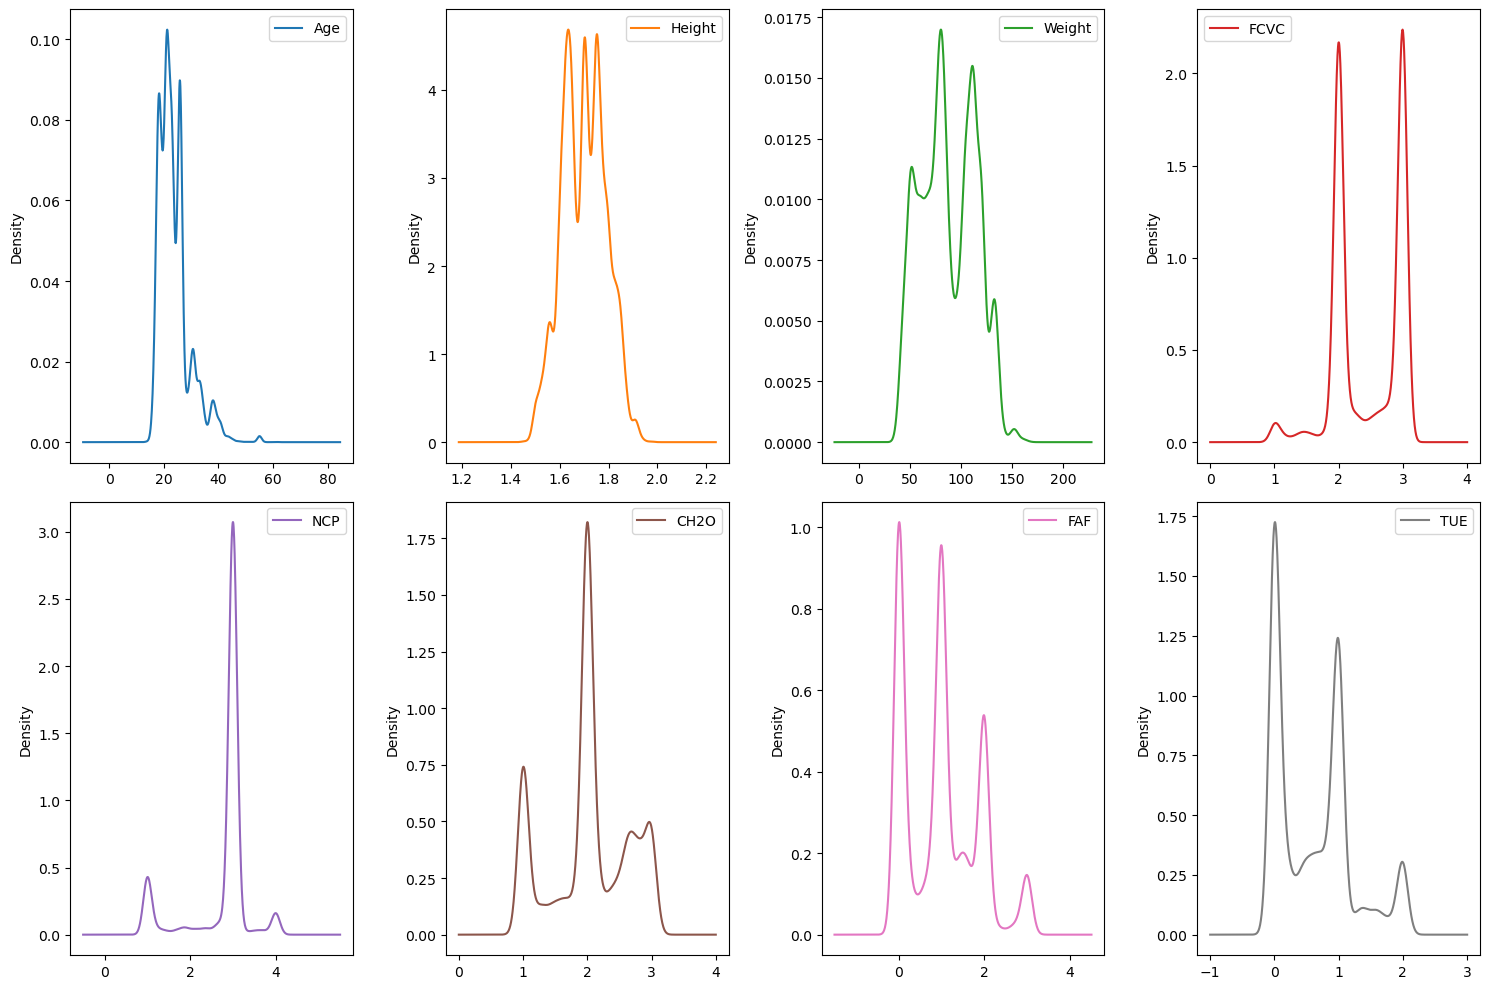

In [7]:
numerical_cols = [name for name, col in df.items() if not is_object_dtype(col) and name != "id"]
plot_numerical_distr(df, numerical_cols, (15, 10))
plt.tight_layout()

## Preprocessing ##

In [8]:
X, y, x_encoder, y_encoder = preprocess(df)
print_stats(X)

head


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,BMI,BMI_group,FAVC-FCVC,BMI*FAF,FAF-TUE,FCVC*NCP,BMI/NCP,Age_group
id,,,,,,,,,,,,,,,,,,,,,
0,1.0,24.443011,1.699998,81.669950,1.0,1.0,2.000000,2.983297,2.0,0.0,...,1.0,3.0,28.259565,2,-1.000000,0.000000,-0.976473,5.966594,9.472595,2
1,0.0,18.000000,1.560000,57.000000,1.0,1.0,2.000000,3.000000,1.0,0.0,...,2.0,0.0,23.422091,1,-1.000000,23.422091,0.000000,6.000000,7.807364,1
2,0.0,18.000000,1.711460,50.165754,1.0,1.0,1.880534,1.411685,2.0,0.0,...,2.0,3.0,17.126706,0,-0.880534,14.832498,-0.807539,2.654722,12.132102,1
3,0.0,20.952737,1.710730,131.274851,1.0,1.0,3.000000,3.000000,2.0,0.0,...,1.0,3.0,44.855798,5,-2.000000,65.842167,0.687664,9.000000,14.951933,2
4,1.0,31.641081,1.914186,93.798055,1.0,1.0,2.679664,1.971472,2.0,0.0,...,1.0,3.0,25.599151,2,-1.679664,50.378438,1.036252,5.282883,12.984791,3


description


,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,...,CALC,MTRANS,BMI,BMI_group,FAVC-FCVC,BMI*FAF,FAF-TUE,FCVC*NCP,BMI/NCP,Age_group
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,...,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,0.497929,23.841804,1.700245,87.887768,0.819636,0.914443,2.445908,2.761332,1.848299,0.011803,...,1.223239,2.506841,30.241842,2.576212,-1.531466,28.221092,0.364990,6.796596,12.304091,1.914009
std,0.500008,5.688072,0.087312,26.379443,0.384500,0.279716,0.533218,0.705375,0.449036,0.108000,...,0.473690,1.148730,8.333932,1.605636,0.600407,25.021787,1.021703,2.356030,6.215130,0.673217
min,0.000000,14.000000,1.450000,39.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,12.868541,0.000000,-3.000000,0.000000,-2.000000,1.000000,3.499342,1.000000
25%,0.000000,20.000000,1.631856,66.000000,1.000000,1.000000,2.000000,3.000000,2.000000,0.000000,...,1.000000,3.000000,24.088223,1.000000,-2.000000,0.292893,-0.274914,6.000000,8.230135,2.000000
50%,0.000000,22.815416,1.700000,84.064875,1.000000,1.000000,2.393837,3.000000,2.000000,0.000000,...,1.000000,3.000000,29.384757,2.000000,-1.722161,25.926479,0.285889,6.453894,11.388960,2.000000
75%,1.000000,26.000000,1.762887,111.600553,1.000000,1.000000,3.000000,3.000000,2.000000,0.000000,...,1.000000,3.000000,37.011168,4.000000,-1.000000,43.342516,1.000000,9.000000,13.922076,2.000000
max,1.000000,61.000000,1.975663,165.057269,1.000000,1.000000,3.000000,4.000000,3.000000,1.000000,...,2.000000,4.000000,54.997991,5.000000,0.000000,136.630030,3.000000,12.000000,43.377982,6.000000


info
<class 'pandas.core.frame.DataFrame'>
Index: 20758 entries, 0 to 20757
Data columns (total 24 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   Gender                          20758 non-null  float64
 1   Age                             20758 non-null  float64
 2   Height                          20758 non-null  float64
 3   Weight                          20758 non-null  float64
 4   family_history_with_overweight  20758 non-null  float64
 5   FAVC                            20758 non-null  float64
 6   FCVC                            20758 non-null  float64
 7   NCP                             20758 non-null  float64
 8   CAEC                            20758 non-null  float64
 9   SMOKE                           20758 non-null  float64
 10  CH2O                            20758 non-null  float64
 11  SCC                             20758 non-null  float64
 12  FAF                             

         index   variable      corr
88         BMI     Weight  0.941071
89   BMI_group     Weight  0.923719
307    BMI*FAF        FAF  0.909766
424        BMI  BMI_group  0.983349


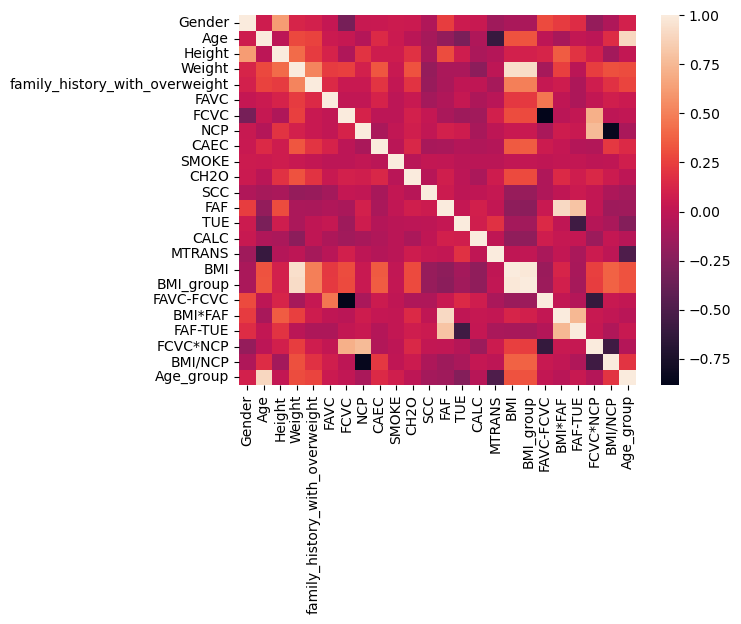

In [9]:
plot_correlation(X)
print(get_top_correlations(X, 0.9))
X = X.drop(["BMI"], axis=1)

In [10]:
X = X.to_numpy()
y = y.to_numpy()

## Simulation ##

100%|██████████| 20758/20758 [00:00<00:00, 24394.94it/s]


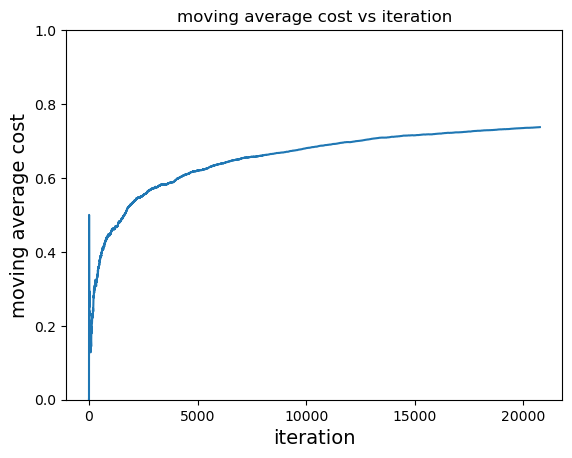

In [11]:
A = np.unique(y)
model = Workspace(f"--cb_explore {len(A)} --first 100", enable_logging=True)
actions, costs = simulate(model, X, y, A, True)
avg_costs = costs_to_moving_avg(costs)
plot_average_costs(avg_costs)
plt.show()

## Scores ##

In [12]:
avg_regret = 1 - avg_costs[-1]
avg_regret

0.2624530301570479

In [13]:
train_acc = -sum(simulate(model, X, y, A, False)[1])/len(X)
train_acc

100%|██████████| 20758/20758 [00:00<00:00, 61749.80it/s]


0.8608729164659409

## Test set (unnecessary) ##

In [14]:
test_X, _, _ = preprocess(pd.read_csv(test_path), x_encoder, y_encoder, True)
test_actions = evaluate(model, test_X.to_numpy(), A)
pd.DataFrame({"id": test_X.index, "NObeyesdad": y_encoder.inverse_transform(np.array(test_actions) - 1)}).to_csv(submission_path, index=False)

In [15]:
model.finish()
model.get_log()

['using no cache',
 'Reading datafile = none',
 'num sources = 0',
 'Num weight bits = 18',
 'learning rate = 0.5',
 'initial_t = 0',
 'power_t = 0.5',
 'cb_type = mtr',
 'Enabled learners: gd, scorer-identity, csoaa_ldf-rank, cb_adf, cb_explore_adf_first, shared_feature_merger, cb_to_cbadf',
 'Input label = CB',
 'Output pred = ACTION_PROBS',
 'average  since         example        example        current        current  current',
 'loss     last          counter         weight          label        predict features',
 'n.a.     n.a.                1            1.0        unknown         0:0.14      168',
 'n.a.     n.a.                2            2.0        unknown         0:0.14      168',
 'n.a.     n.a.                4            4.0        unknown         0:0.14      168',
 'n.a.     n.a.                8            8.0        unknown         0:0.14      168',
 'n.a.     n.a.               16           16.0        unknown         3:0.14      168',
 'n.a.     n.a.               3